# crear un virtualenv

## 1) Crear un entorno
python3 -m venv ~/.venvs/astro

## 2) Activarlo
source ~/.venvs/astro/bin/activate

## 3) Actualizar pip e instalar paquetes
python -m pip install --upgrade pip
pip install scikit-image astropy reproject matplotlib

## (Opcional) hacer disponible este entorno en Jupyter
pip install ipykernel
python -m ipykernel install --user --name astro-venv --display-name "Python (astro-venv)"


# Getting JWST Data

All JWST data becomes publicly available after a 12-month proprietary period. You can download raw data from the MAST Portal.

Steps to download data:

    1) Go to the MAST Portal
    2) Click "Advanced Search"
    3) Filter by Mission: "JWST" and Instrument: "NIRCAM" and/or "MIRI"
    4) Enter an object name (e.g., "Carina Nebula" or "NGC 3324")
    6) Select the files ending in _i2d.fits (Level 3 calibrated images)
    7) Download the data


**Nota (celda 1) — Imports y configuración inicial del tutorial.**


In [1]:
# JWST Image Processing Tutorial
# ============================
#
# This notebook demonstrates how to process raw James Webb Space Telescope (JWST) images into beautiful,
# colorized composite images that you can use in your own projects or just admire.

import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
from reproject import reproject_interp

from skimage import exposure, color
from skimage.io import imread, imsave
from skimage.util import img_as_ubyte
from dataclasses import dataclass, fields
from PIL import Image
from IPython.display import display
from typing import Dict, List, Tuple, Any
import warnings

# Suppress warnings that might clutter our output
warnings.simplefilter("ignore")

# Increase max image size for PIL to handle large JWST images
Image.MAX_IMAGE_PIXELS = None

# Display settings for better visualization
plt.rcParams['figure.figsize'] = (12, 10)

**Nota (celda 2) — Código auxiliar de soporte para el flujo del tutorial.**

es una **dataclass**, contenedor muy ligero de metadatos sobre cada filtro del JWST. Sirve para describir un filtro y poder referenciarlo en el flujo sin cargar datos pesados.


In [2]:
# Cell 2: Define the metadata structures
# =====================================

@dataclass()
class WebbFilter:
    """Stores information about a filter on JWST and its transmission characteristics."""
    name: str
    instrument: str
    wavelength: float
    bandwidth: float
    is_pupil: bool = False

    def get_filter_name(self):
        """Returns a filter name in the format `INSTRUMENT-FILTER`."""
        return self.instrument + "-" + self.name


class MetadataContainer:
    """Container for filter information that can be accessed as list or dictionary."""
    def __init__(self, dataclass_list: list):
        self.list = dataclass_list
        self.dict = {getattr(obj, fields(obj)[0].name): obj for obj in dataclass_list}


# Define JWST filter information
class WebbFilters:
    """Stores information about the filters on NIRCAM and MIRI."""
    FILTERS = {
        # NIRCAM filters data
        "NIRCAM": MetadataContainer(
            [
                WebbFilter("F070W", "NIRCAM", 0.704, 0.128, False),
                WebbFilter("F090W", "NIRCAM", 0.901, 0.194, False),
                WebbFilter("F115W", "NIRCAM", 1.154, 0.225, False),
                WebbFilter("F140M", "NIRCAM", 1.404, 0.142, False),
                WebbFilter("F150W", "NIRCAM", 1.501, 0.318, False),
                WebbFilter("F162M", "NIRCAM", 1.626, 0.168, True),
                WebbFilter("F164N", "NIRCAM", 1.644, 0.020, True),
                WebbFilter("F150W2", "NIRCAM", 1.671, 1.227, False),
                WebbFilter("F182M", "NIRCAM", 1.845, 0.238, False),
                WebbFilter("F187N", "NIRCAM", 1.874, 0.024, False),
                WebbFilter("F200W", "NIRCAM", 1.990, 0.461, False),
                WebbFilter("F210M", "NIRCAM", 2.093, 0.205, False),
                WebbFilter("F212N", "NIRCAM", 2.120, 0.027, False),
                WebbFilter("F250M", "NIRCAM", 2.503, 0.181, False),
                WebbFilter("F277W", "NIRCAM", 2.786, 0.672, False),
                WebbFilter("F300M", "NIRCAM", 2.996, 0.318, False),
                WebbFilter("F322W2", "NIRCAM", 3.247, 1.339, False),
                WebbFilter("F323N", "NIRCAM", 3.237, 0.038, True),
                WebbFilter("F335M", "NIRCAM", 3.365, 0.347, False),
                WebbFilter("F356W", "NIRCAM", 3.563, 0.787, False),
                WebbFilter("F360M", "NIRCAM", 3.621, 0.372, False),
                WebbFilter("F405N", "NIRCAM", 4.055, 0.046, True),
                WebbFilter("F410M", "NIRCAM", 4.092, 0.436, False),
                WebbFilter("F430M", "NIRCAM", 4.280, 0.228, False),
                WebbFilter("F444W", "NIRCAM", 4.421, 1.024, False),
                WebbFilter("F460M", "NIRCAM", 4.624, 0.228, False),
                WebbFilter("F466N", "NIRCAM", 4.654, 0.054, True),
                WebbFilter("F470N", "NIRCAM", 4.707, 0.051, True),
                WebbFilter("F480M", "NIRCAM", 4.834, 0.303, False),
            ]
        ),
        # MIRI filters data
        "MIRI": MetadataContainer(
            [
                WebbFilter("F560W", "MIRI", 5.6, 1.2),
                WebbFilter("F770W", "MIRI", 7.7, 2.2),
                WebbFilter("F1000W", "MIRI", 10.0, 2.0),
                WebbFilter("F1130W", "MIRI", 11.3, 0.7),
                WebbFilter("F1280W", "MIRI", 12.8, 2.4),
                WebbFilter("F1500W", "MIRI", 15.0, 3.0),
                WebbFilter("F1800W", "MIRI", 18.0, 3.0),
                WebbFilter("F2100W", "MIRI", 21.0, 5.0),
                WebbFilter("F2550W", "MIRI", 25.5, 4.0),
                WebbFilter("F2550WR", "MIRI", 25.5, 4.0),
                WebbFilter("FND", "MIRI", 13, 10),
            ]
        ),
    }

print("Metadata structures defined successfully!")

Metadata structures defined successfully!


**Nota (celda 3) — Clase WebbsterFITS: lectura segura con memmap, previews y métodos de reproyección.**

clase para trabajar con un FITS de JWST: lo abre, expone su WCS/metadata, saca previews y (si quieres) lo reproyecta/alianea contra otra imagen, y finalmente te permite guardar una vista en PNG/JPG.


In [3]:
# Cell 3: Define the FITS processing class
# =======================================

class WebbsterFITS:
    """Processes FITS files from JWST and helps perform image operations."""

    def __init__(self, filepath: str):
        """
        Opens the file at `filepath`, gets data from FITS HDUList object, and
        uses it to populate fields.
        """
        self.filepath = filepath
        self.hdul = fits.open(self.filepath)
        self.fits_filename = self.hdul[0].header["FILENAME"].upper()
        self.hdu = self.hdul[1]
        self.naxis1 = self.hdu.header["NAXIS1"]
        self.naxis2 = self.hdu.header["NAXIS2"]
        self.res = self.naxis1 * self.naxis2
        self.data = self.hdu.data
        self.filter = self.get_filter()
        self.name = self.filter.get_filter_name() if self.filter else "NONE"
        
        # Display basic information about the image
        print(f"Loaded: {os.path.basename(filepath)}")
        print(f"Filter: {self.name}")
        print(f"Size: {self.naxis1} x {self.naxis2} pixels")
        print(f"Resolution: {self.res} pixels")

    def get_filter(self) -> WebbFilter:
        """
        Gets filter by searching for an instance of a filter name in fits
        filename. If there are multiple instances, prefers the one that is on
        the pupil wheel, or appears last.
        """
        # Get instrument and filter names from fits filename
        try:
            name_parts = self.fits_filename.split("_")
            instrument = name_parts[2]
            filters = name_parts[3].split("-")
        except:
            return None

        # Get dictionary of filters for the specific instrument
        if instrument not in WebbFilters.FILTERS:
            return None
        instrument_filters = WebbFilters.FILTERS[instrument].dict

        # Find appropriate filter
        fits_filter = None
        for filter in reversed(filters):
            if filter in instrument_filters and (
                fits_filter is None or instrument_filters[filter].is_pupil
            ):
                fits_filter = instrument_filters[filter]

        return fits_filter

    def display_raw_data(self):
        """Display the raw data with appropriate scaling."""
        # Get min and max for display
        vmin, vmax = np.percentile(self.data, (1, 99.5))
        
        plt.figure()
        plt.imshow(self.data, cmap='gray', vmin=vmin, vmax=vmax, origin='lower')
        plt.colorbar(label='Raw intensity values')
        plt.title(f"Raw FITS data for {self.name}")
        plt.show()

    def adjust_contrast(self):
        """
        Stretches out the darker portions of the image for better visibility.
        Handles NaN values that might be present in the FITS data.
        """
        # Handle NaN values by replacing them with zeros
        if np.isnan(self.data).any():
            print("Warning: NaN values detected in the data. Replacing with zeros.")
            self.data = np.nan_to_num(self.data, nan=0.0)
        
        # Display original histogram
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.hist(self.data.flatten(), bins=100)
        plt.title("Original intensity distribution")
        plt.yscale('log')
        
        # Rescale intensity (clip darkest and brightest areas)
        lo, hi = np.percentile(self.data, (15, 99.85))
        print(f"Stretching contrast: clipping values below {lo:.6f} and above {hi:.6f}")
        self.data = exposure.rescale_intensity(self.data, in_range=(lo, hi))
        self.data = np.clip(self.data, 0.0, 1.0)
        
        # Display mid-processing histogram
        plt.subplot(1, 3, 2)
        plt.hist(self.data.flatten(), bins=100)
        plt.title("After linear stretching")
        plt.yscale('log')
        
        # Adaptive histogram equalization
        print("Applying adaptive histogram equalization...")
        self.data = exposure.equalize_adapthist(self.data, clip_limit=0.02)
        
        # Display final histogram
        plt.subplot(1, 3, 3)
        plt.hist(self.data.flatten(), bins=100)
        plt.title("After histogram equalization")
        plt.yscale('log')
        plt.tight_layout()
        plt.show()
        
        # Display the adjusted image
        plt.figure()
        plt.imshow(self.data, cmap='gray', origin='lower')
        plt.colorbar(label='Adjusted intensity values')
        plt.title(f"Contrast-adjusted image for {self.name}")
        plt.show()

    def reproject(self, ref_fits: "WebbsterFITS", max_pixels: int = 50_000_000):
        """
        Reprojects image to be aligned with `ref_fits` using WCS data.
        To save on memory, the image is processed in slices.
        """
        print(f"Reprojecting {self.name} to match {ref_fits.name}...")
        print(f"This may take a while for large images...")
        
        start_row = 0
        max_rows = max_pixels // ref_fits.naxis1
        # Empty array to which slices will be concatenated
        proj_data = np.empty((0, ref_fits.naxis1), dtype=np.uint8)
        
        while start_row < ref_fits.naxis2:
            if ref_fits.naxis2 - start_row > max_rows:
                end_row = start_row + max_rows
            else:
                end_row = ref_fits.naxis2
                
            print(f"Processing rows {start_row} to {end_row}...")
            
            # Slice the WCS of the reference image
            ref_wcs = WCS(ref_fits.hdu.header)
            ref_wcs = ref_wcs[start_row:end_row, 0 : ref_fits.naxis1]
            slice_shape = (end_row - start_row, ref_fits.naxis1)
            
            # Reproject, and convert to uint8 to save memory
            proj_slice = img_as_ubyte(
                reproject_interp(
                    (self.data, self.hdu.header), ref_wcs, shape_out=slice_shape
                )[0]
            )
            
            # Concatenate new slice onto the end of our image
            proj_data = np.concatenate((proj_data, proj_slice))
            start_row = end_row
            
        # Set data to reprojected data
        self.data = proj_data
        print(f"Reprojection of {self.name} complete!")
        
        # Display the reprojected image
        plt.figure()
        plt.imshow(self.data, cmap='gray', origin='lower')
        plt.title(f"Reprojected image for {self.name}")
        plt.show()

    def save_image(
        self, folder: str = None, filename: str = None, extension: str = "png"
    ) -> str:
        """
        Converts data to uint8 and optionally saves as image.
        """
        self.png_data = img_as_ubyte(self.data)
        self.png_data = np.flipud(self.png_data)
        
        if folder:
            os.makedirs(folder, exist_ok=True)
            filepath = os.path.join(
                folder,
                filename
                or f"{self.fits_filename.split('-')[0]}_{self.name}.{extension}",
            )
            print(f"Saving layer image to {filepath}")
            imsave(filepath, self.png_data)
            return filepath
        
        return None

**Nota (celda 4) — Código auxiliar de soporte para el flujo del tutorial.**



In [4]:
# Cell 4: Define the Layer Processing Class
# ========================================

class WebbsterLayer:
    """Helps colorize a grayscale layer and process image data."""

    @staticmethod
    def fromImageFile(
        image_file: str,
        hue: float = None,
        saturation: float = None,
        value: float = None,
        filter: WebbFilter = None,
    ) -> "WebbsterLayer":
        """Creates WebbsterLayer from an image file."""
        # If no filter is provided, look for filter name in the filename
        if not filter:
            try:
                instrument, filter_name = (
                    os.path.basename(image_file).upper().split(".")[0].split("_")[1].split("-")
                )
            except:
                instrument = None
                filter_name = None

            if (
                instrument
                and filter_name
                and instrument in WebbFilters.FILTERS
                and filter_name in WebbFilters.FILTERS[instrument].dict
            ):
                filter = WebbFilters.FILTERS[instrument].dict[filter_name]

        hue, saturation, value = WebbsterLayer.get_hsv(
            hue, saturation, value, filter, strict=True
        )
        return WebbsterLayer(
            imread(image_file), os.path.basename(image_file), hue, saturation, value, image_file
        )

    @staticmethod
    def fromFITS(
        fits: WebbsterFITS,
        hue: float = None,
        saturation: float = None,
        value: float = None,
        filter: WebbFilter = None,
    ) -> "WebbsterLayer":
        """Creates WebbsterLayer from a WebbsterFITS."""
        hue, saturation, value = WebbsterLayer.get_hsv(
            hue,
            saturation,
            value,
            filter or fits.filter,
        )
        return WebbsterLayer(fits.png_data, fits.name, hue, saturation, value)

    def __init__(
        self,
        image: Any,
        name: str,
        hue: float,
        saturation: float,
        value: float,
        filepath: str = None,
    ):
        """Creates WebbsterLayer from the given image data, name, and HSV."""
        self.gray_image = image
        self.name = name
        self.hue = hue
        self.saturation = saturation
        self.value = value
        if filepath:
            self.filepath = filepath
        
        print(f"Created layer: {name}")
        print(f"HSV values: H={hue*360:.1f}°, S={saturation*100:.1f}%, V={value*100:.1f}%")
        
        # Display a small preview of the grayscale image
        plt.figure(figsize=(5, 5))
        plt.imshow(self.gray_image, cmap='gray')
        plt.title(f"Grayscale preview: {name}")
        plt.show()

    def colorize(self):
        """
        Colorize the grayscale image and set color_image to new RGB image.
        """
        print(f"Colorizing {self.name} with HSV: ({self.hue*360:.1f}°, {self.saturation*100:.1f}%, {self.value*100:.1f}%)")
        
        rgb = color.gray2rgb(self.gray_image)
        multiplier = np.array(
            [self.hue, self.saturation, self.value],
            dtype=np.float64,
        )
        multiplier = color.hsv2rgb(multiplier)
        self.color_image = (rgb * multiplier).astype(np.uint8)
        
        # Display the colorized image
        plt.figure(figsize=(8, 8))
        plt.imshow(self.color_image)
        plt.title(f"Colorized image: {self.name}")
        plt.show()
        
        return self.color_image

    @staticmethod
    def get_hsv(
        hue: float = None,
        saturation: float = None,
        value: float = None,
        filter: WebbFilter = None,
        strict: bool = False,
    ) -> Tuple[float, float, float]:
        """Returns a tuple of (hue, saturation, value) based on the input."""
        new_hue = new_saturation = None

        if filter:
            new_hue, new_saturation = WebbsterLayer.get_filter_hue_saturation(filter)
        if hue is None:
            hue = new_hue
        if saturation is None:
            saturation = new_saturation

        if (hue is None or saturation is None) and strict:
            raise ValueError(
                "Must at least provide either filter or hue and saturation."
            )

        return (hue, saturation, 1 if value is None else value)

    @staticmethod
    def get_filter_hue_saturation(filter: WebbFilter) -> Tuple[float, float]:
        """
        Gets representative hue and saturation for a filter based on the
        filter's pivot wavelength and bandwidth.
        """
        # If there is no filter, this layer will be grayscale
        if not filter:
            return (0, 0)

        # Each filter is given a hue based on where its wavelength falls in
        # relation to the entire range of the filter's instrument, and a
        # saturation based on its bandwidth.
        instrument_filters = WebbFilters.FILTERS[filter.instrument].list
        all_bandwidths = [filter.bandwidth for filter in instrument_filters]
        bw_range = (min(all_bandwidths), max(all_bandwidths))
        all_wavelengths = [filter.wavelength for filter in instrument_filters]
        wl_range = (min(all_wavelengths), max(all_wavelengths))

        hue_range = (0, 240 / 360)
        saturation_range = (0, 1)

        # Get the proportion of the wavelength on the wavelength range
        wl_prop = (filter.wavelength - wl_range[0]) / (wl_range[1] - wl_range[0])
        # Adjust the proportion according to an S-curve to avoid too much green
        wl_prop_adj = wl_prop
        try:
            wl_prop_adj = 1 / (1 + (wl_prop / (1 - wl_prop)) ** -2)
        except:
            wl_prop_adj = round(wl_prop)
        # Convert adjusted proportion to hue (inverted because wavelength is inversely proportional to hue)
        hue = hue_range[1] - wl_prop_adj * (hue_range[1] - hue_range[0])

        # Get the proportion of the bandwidth on the bandwidth range
        bw_prop = (filter.bandwidth - bw_range[0]) / (bw_range[1] - bw_range[0])
        saturation = saturation_range[1] - bw_prop * (
            saturation_range[1] - saturation_range[0]
        )

        return (hue, saturation)

**Nota (celda 5) — Código auxiliar de soporte para el flujo del tutorial.**



In [5]:
# Cell 5: Define the Blending Functions
# ====================================

def screen_blend(image1: Any, image2: Any):
    """
    Screen blend two RGB uint8 images.
    Similar to how light combines when projected through film.
    """
    return 255 - np.floor_divide(
        (255 - image1).astype(np.uint) * (255 - image2).astype(np.uint), 255
    ).astype(np.uint8)


def screen_blend_multiple(images: List[np.ndarray], brightness: float = None):
    """
    Blends multiple images using screen blending.
    Decreases the brightness of each image based on the number of layers.
    """
    if not images:
        return None
        
    # When there are more layers, we reduce brightness to compensate
    brightness = 1 - 0.05 * len(images) if brightness is None else brightness
    print(f"Blending {len(images)} images with brightness factor of {brightness:.2f}")

    # Start with the first image
    blended = images[0].copy()
    
    # Display the first image
    plt.figure(figsize=(8, 8))
    plt.imshow(blended)
    plt.title(f"Starting with first layer")
    plt.show()
    
    # Blend each subsequent image
    for i in range(1, len(images)):
        multiplier = np.array([brightness, brightness, brightness], dtype=np.float64)
        new_image = (images[i] * multiplier).astype(np.uint8)
        
        # Show the layer being added
        plt.figure(figsize=(15, 8))
        plt.subplot(1, 3, 1)
        plt.imshow(blended)
        plt.title("Current blend")
        
        plt.subplot(1, 3, 2)
        plt.imshow(new_image)
        plt.title(f"Adding layer {i+1}")
        
        # Blend images
        blended = screen_blend(blended, new_image)
        
        plt.subplot(1, 3, 3)
        plt.imshow(blended)
        plt.title("Result after blending")
        plt.tight_layout()
        plt.show()
    
    return blended

**Nota (celda 6) — Ejemplo de reproyección/alineación contra una referencia .**
(En tiles ó bloques 2D D en los que partimos una imagen enorme para procesarla por partes en lugar de cargarla entera en RAM.)



In [6]:
# Cell 6: Define the FITS to Image Pipeline
# =======================================

def process_fits_folder(
    fits_folder: str, 
    output_image: str, 
    layers_folder: str = None,
    layers_extension: str = "png"
):
    """
    Process a folder of FITS files into a single composite image.
    Optionally save the individual layer images.
    """
    # Get a list of all FITS files in the folder
    fits_files = [
        os.path.join(fits_folder, filename)
        for filename in os.listdir(fits_folder)
        if filename.endswith(".fits")
    ]
    
    if not fits_files:
        print(f"No FITS files found in {fits_folder}")
        return
    
    print(f"Found {len(fits_files)} FITS files to process")
    
    # Load each FITS file
    filters = []
    for fits_file in fits_files:
        filters.append(WebbsterFITS(fits_file))
    
    # Find the reference filter with highest resolution
    max_res = 0
    ref_filter = filters[0]
    names = {}
    for filter in filters:
        if filter.res > max_res:
            max_res = filter.res
            ref_filter = filter

        # Handle duplicate filter names
        if filter.name in names:
            names[filter.name] += 1
            filter.name = filter.name + "-" + str(names[filter.name])
        else:
            names[filter.name] = 1

    print(f"Reference filter is {ref_filter.name} with resolution {ref_filter.res} pixels")
    
    # Process each filter
    for filter in filters:
        print(f"\nProcessing {filter.name}...")
        
        # Show the raw data
        filter.display_raw_data()
        
        # Adjust the contrast
        filter.adjust_contrast()
        
        # Reproject if this isn't the reference filter
        if filter != ref_filter:
            filter.reproject(ref_filter)
            
        # Save the layer image if requested
        if layers_folder:
            filter.save_image(layers_folder, extension=layers_extension)
    
    # Convert to layers and colorize
    layers = []
    for filter in filters:
        print(f"\nCreating colorized layer for {filter.name}...")
        layer = WebbsterLayer.fromFITS(filter)
        layer.colorize()
        layers.append(layer)
    
    # Blend the layers
    print("\nBlending all layers together...")
    blended_image = screen_blend_multiple([layer.color_image for layer in layers])
    
    # Display the final image
    plt.figure(figsize=(12, 12))
    plt.imshow(blended_image)
    plt.title("Final composite image")
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    # Save the final image
    os.makedirs(os.path.dirname(output_image) or '.', exist_ok=True)
    imsave(output_image, blended_image)
    print(f"\nSaved final composite image to {output_image}")
    
    return blended_image

**Nota (celda 7) — Código auxiliar de soporte para el flujo del tutorial.**



Found 6 FITS files to process
Loaded: jw01256-o001_t001_nircam_clear-f277w_i2d.fits
Filter: NIRCAM-F277W
Size: 7231 x 10578 pixels
Resolution: 76489518 pixels
Loaded: jw01256-o001_t001_nircam_clear-f182m_i2d.fits
Filter: NIRCAM-F182M
Size: 14675 x 21476 pixels
Resolution: 315160300 pixels
Loaded: jw01256-o001_t001_nircam_clear-f300m_i2d.fits
Filter: NIRCAM-F300M
Size: 7231 x 10577 pixels
Resolution: 76482287 pixels
Loaded: jw01256-o001_t001_nircam_clear-f140m_i2d.fits
Filter: NIRCAM-F140M
Size: 14675 x 21478 pixels
Resolution: 315189650 pixels
Loaded: jw01256-o001_t001_nircam_clear-f187n_i2d.fits
Filter: NIRCAM-F187N
Size: 14680 x 21477 pixels
Resolution: 315282360 pixels
Loaded: jw01256-o001_t001_nircam_clear-f212n_i2d.fits
Filter: NIRCAM-F212N
Size: 14674 x 21474 pixels
Resolution: 315109476 pixels
Reference filter is NIRCAM-F187N with resolution 315282360 pixels

Processing NIRCAM-F277W...


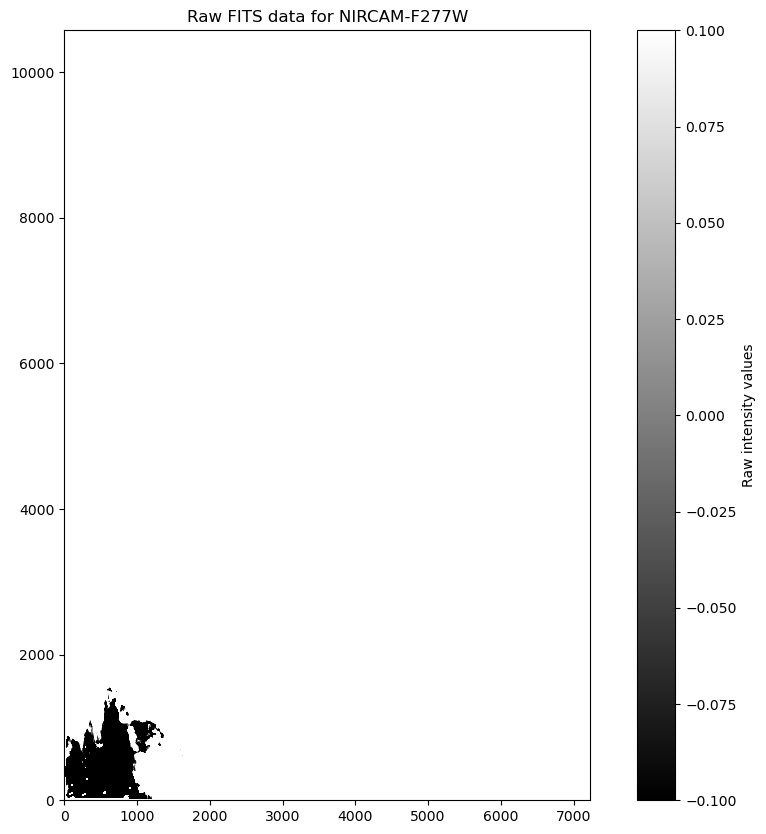

Stretching contrast: clipping values below 2.682638 and above 259.276732
Applying adaptive histogram equalization...


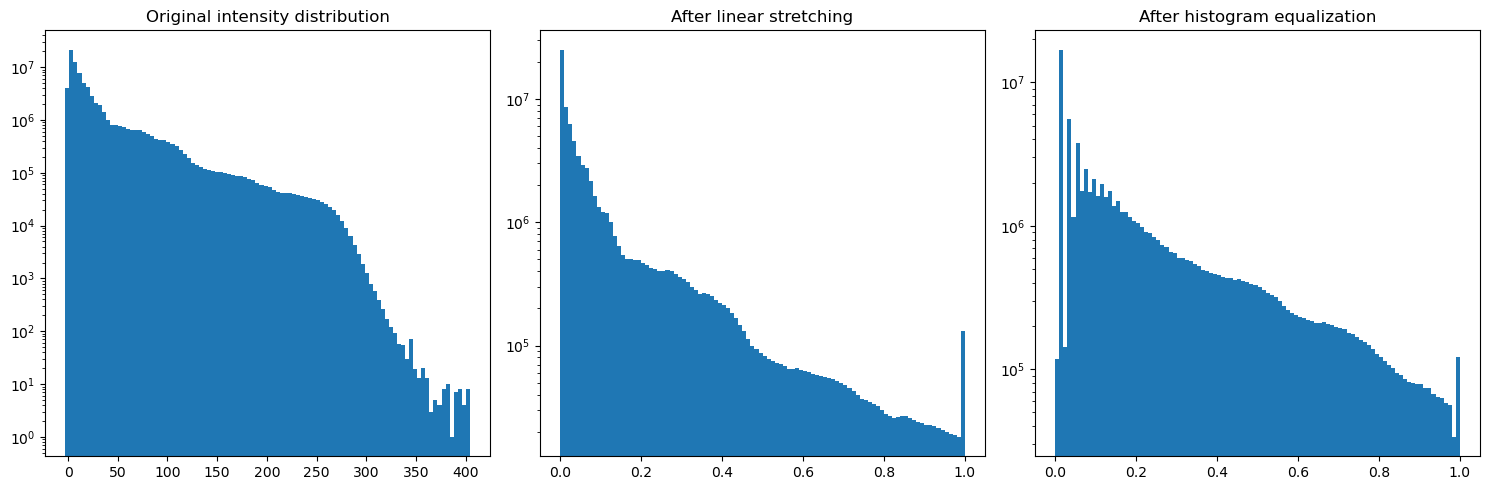

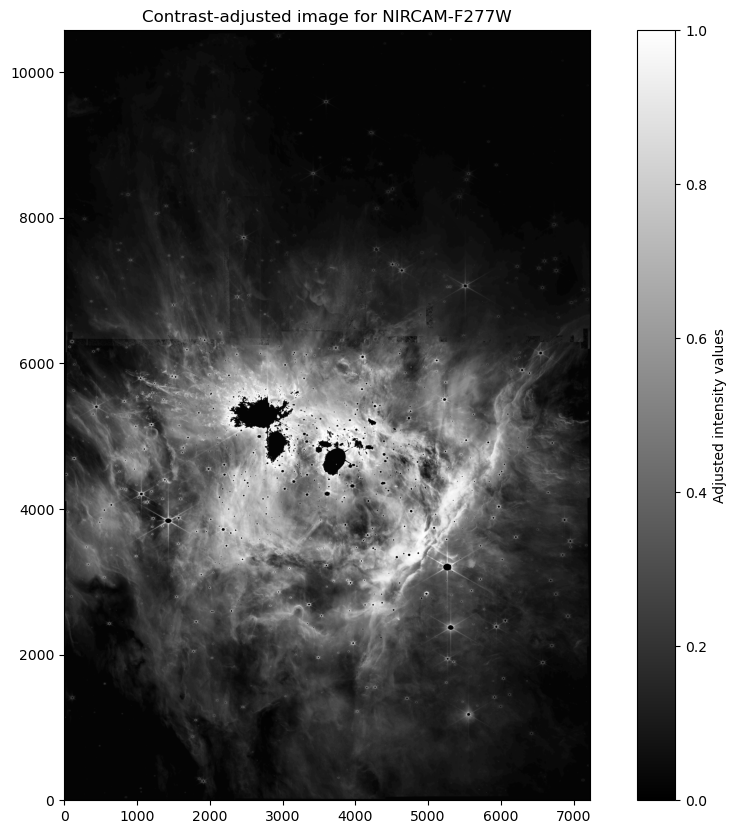

Reprojecting NIRCAM-F277W to match NIRCAM-F187N...
This may take a while for large images...
Processing rows 0 to 3405...
Processing rows 3405 to 6810...
Processing rows 6810 to 10215...
Processing rows 10215 to 13620...
Processing rows 13620 to 17025...
Processing rows 17025 to 20430...
Processing rows 20430 to 21477...
Reprojection of NIRCAM-F277W complete!


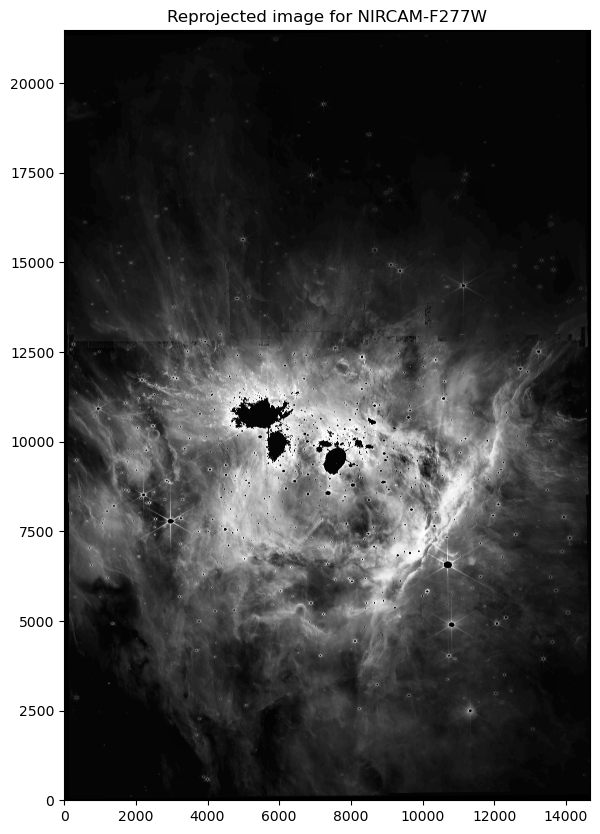

Saving layer image to layers/JW01256_NIRCAM-F277W.png

Processing NIRCAM-F182M...


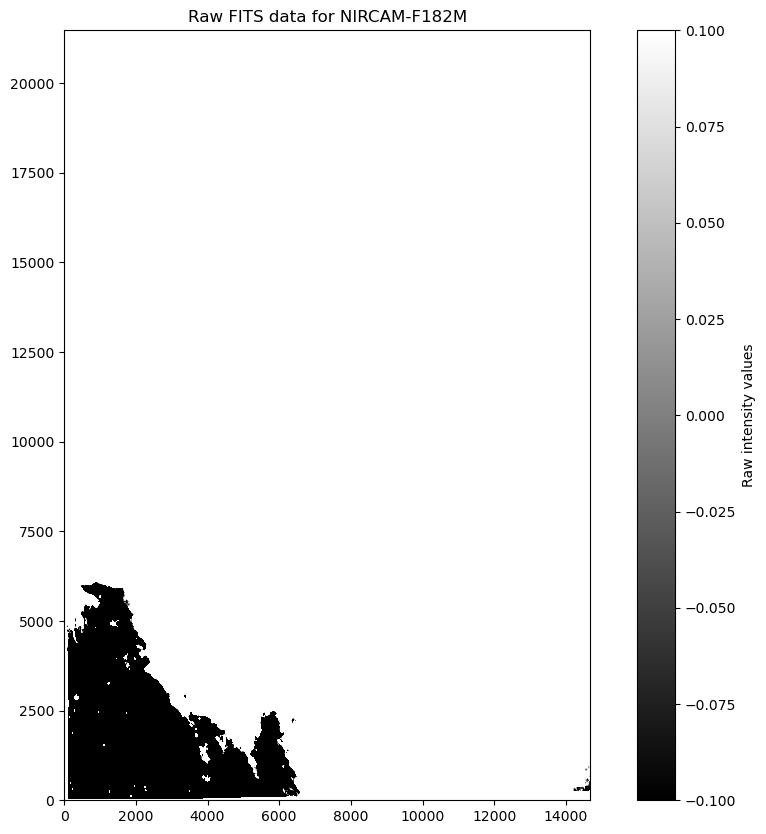

Stretching contrast: clipping values below 2.844590 and above 542.173740
Applying adaptive histogram equalization...


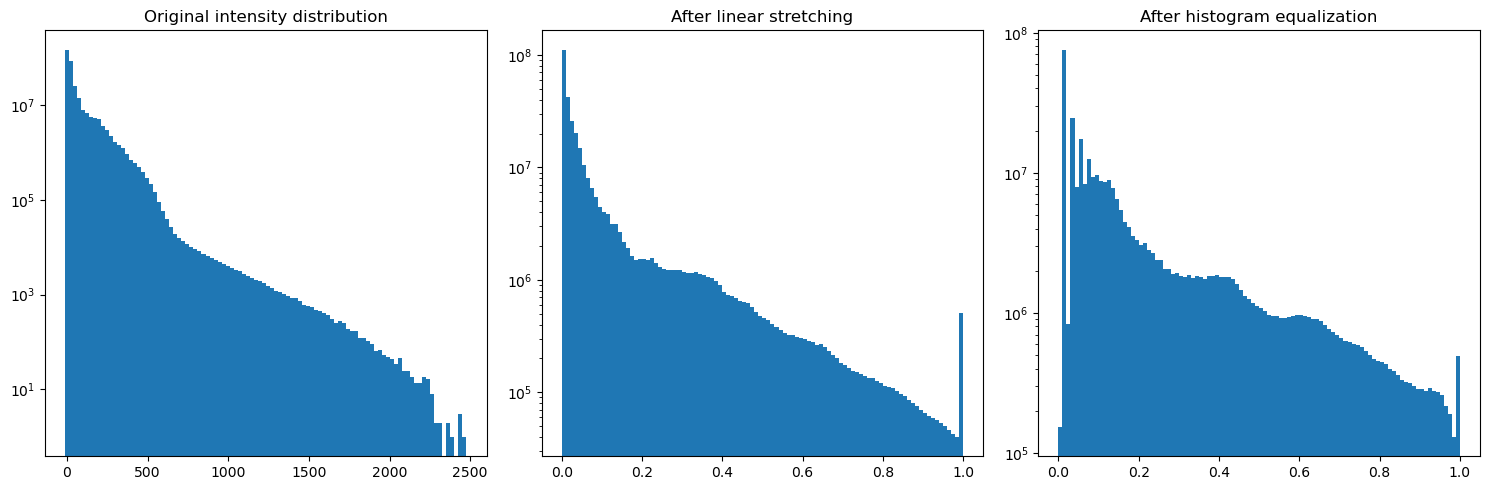

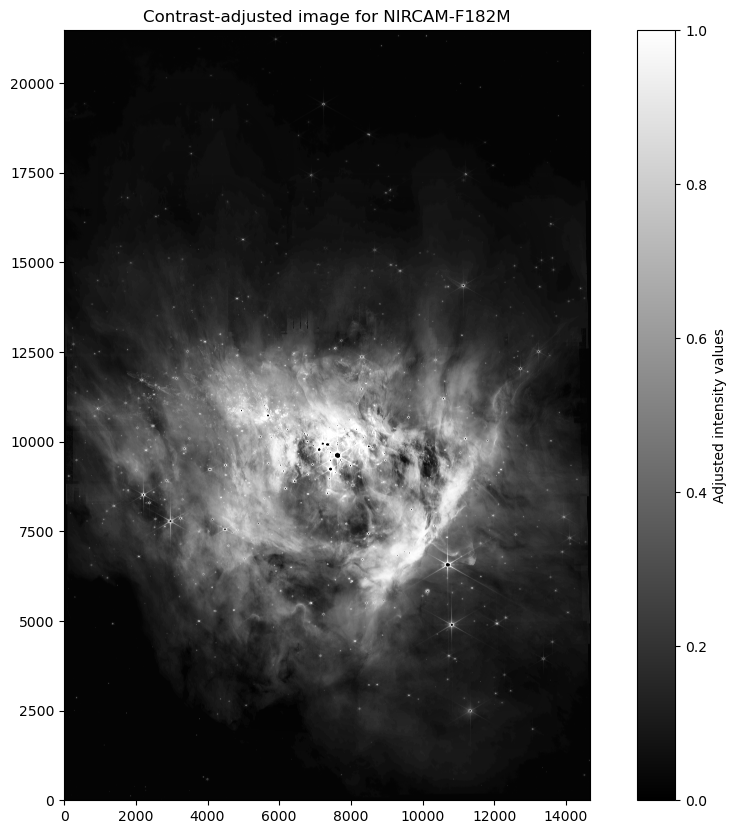

Reprojecting NIRCAM-F182M to match NIRCAM-F187N...
This may take a while for large images...
Processing rows 0 to 3405...
Processing rows 3405 to 6810...
Processing rows 6810 to 10215...
Processing rows 10215 to 13620...
Processing rows 13620 to 17025...
Processing rows 17025 to 20430...
Processing rows 20430 to 21477...
Reprojection of NIRCAM-F182M complete!


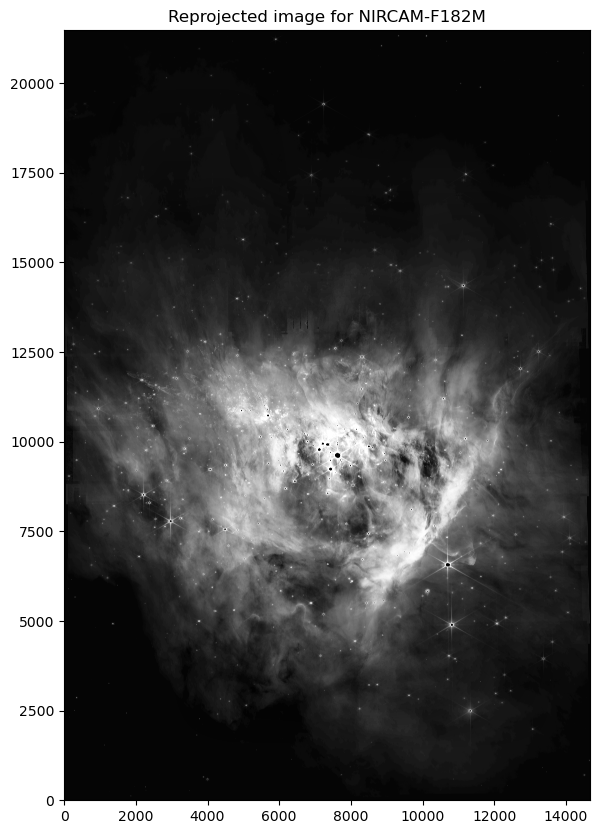

Saving layer image to layers/JW01256_NIRCAM-F182M.png

Processing NIRCAM-F300M...


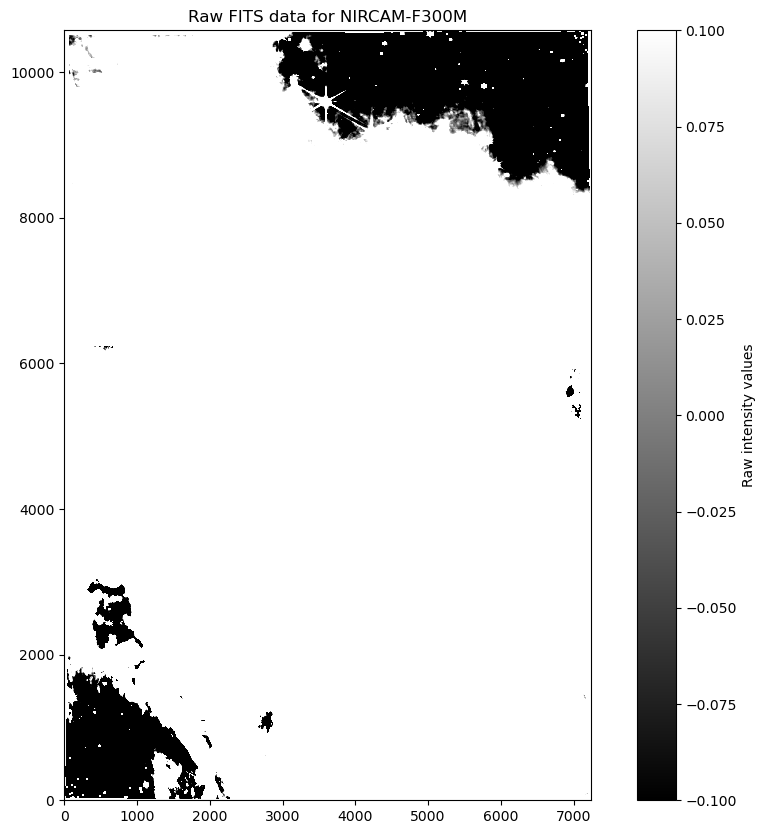

Stretching contrast: clipping values below 0.307409 and above 298.726318
Applying adaptive histogram equalization...


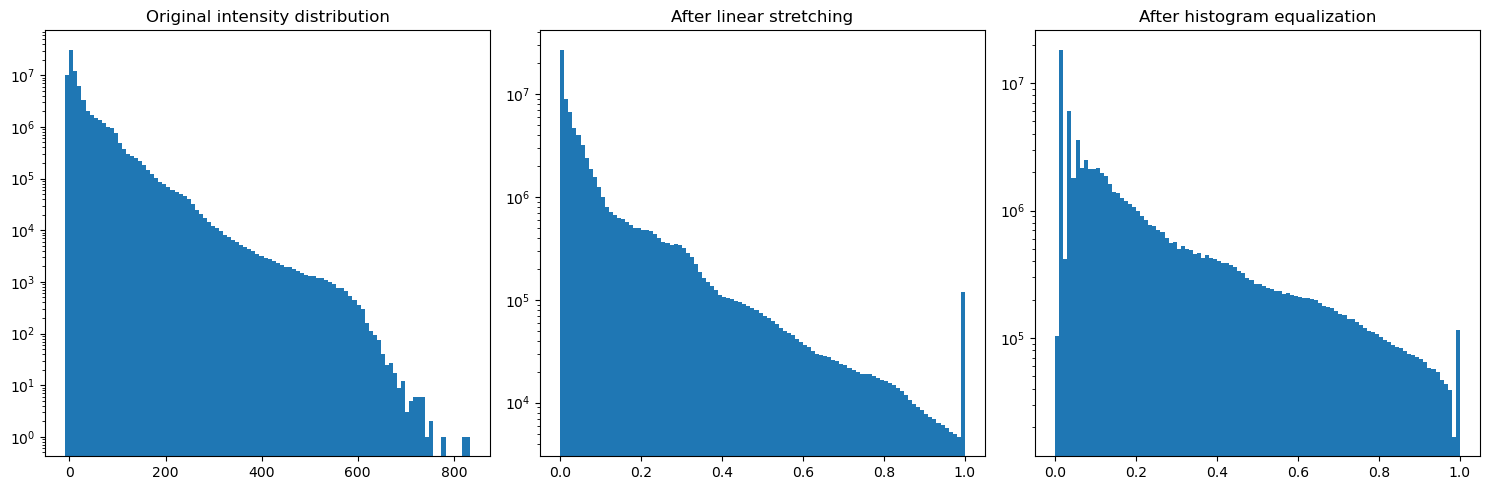

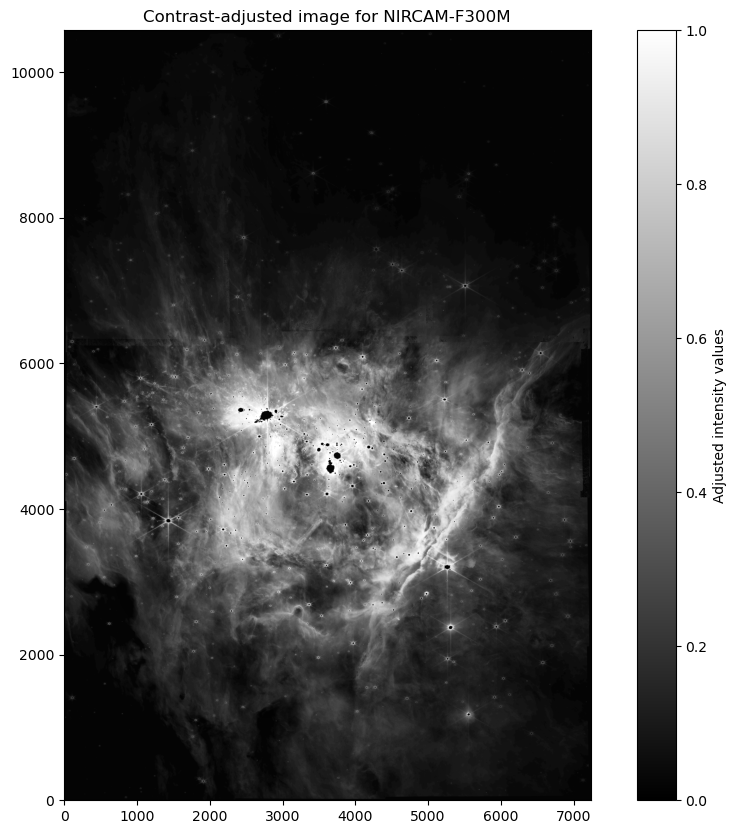

Reprojecting NIRCAM-F300M to match NIRCAM-F187N...
This may take a while for large images...
Processing rows 0 to 3405...
Processing rows 3405 to 6810...
Processing rows 6810 to 10215...
Processing rows 10215 to 13620...
Processing rows 13620 to 17025...
Processing rows 17025 to 20430...
Processing rows 20430 to 21477...
Reprojection of NIRCAM-F300M complete!


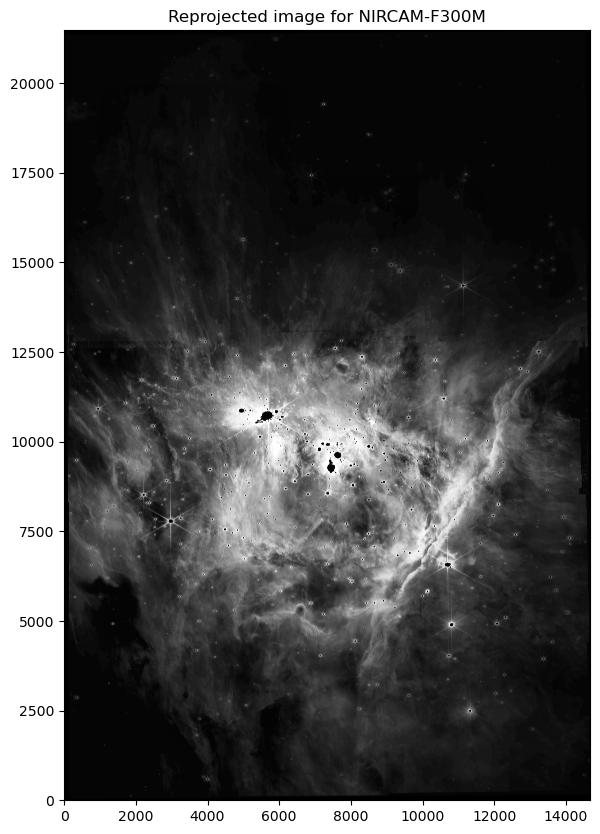

Saving layer image to layers/JW01256_NIRCAM-F300M.png

Processing NIRCAM-F140M...


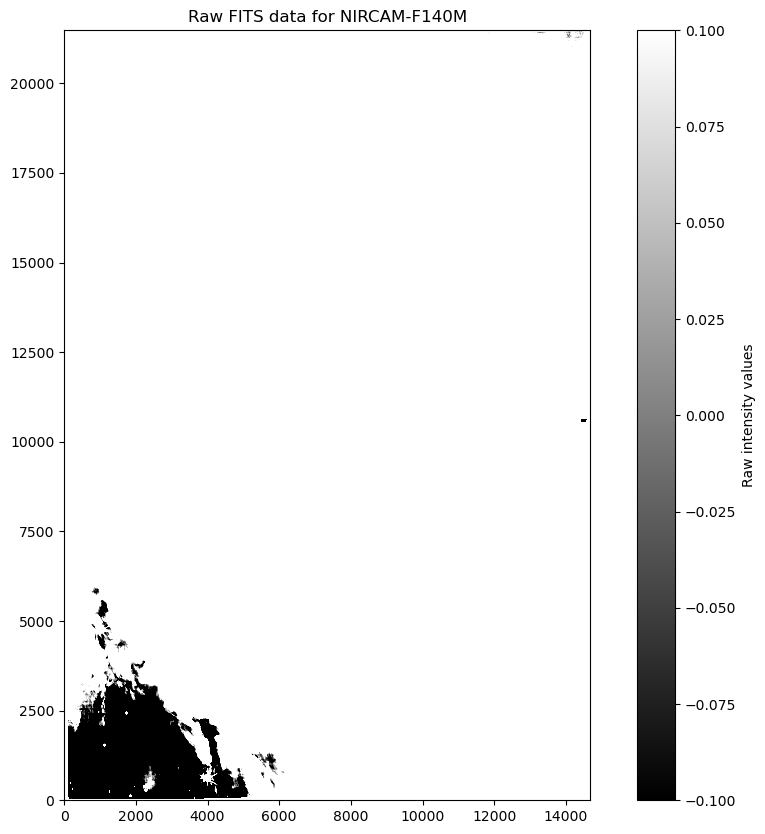

Stretching contrast: clipping values below 0.960504 and above 216.906865
Applying adaptive histogram equalization...


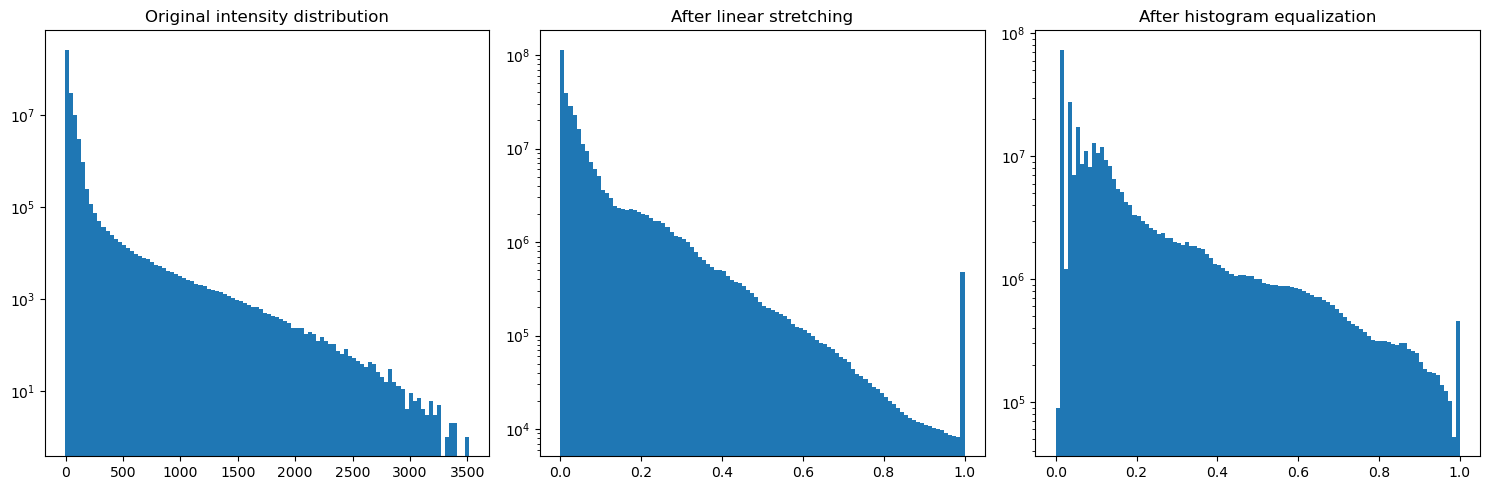

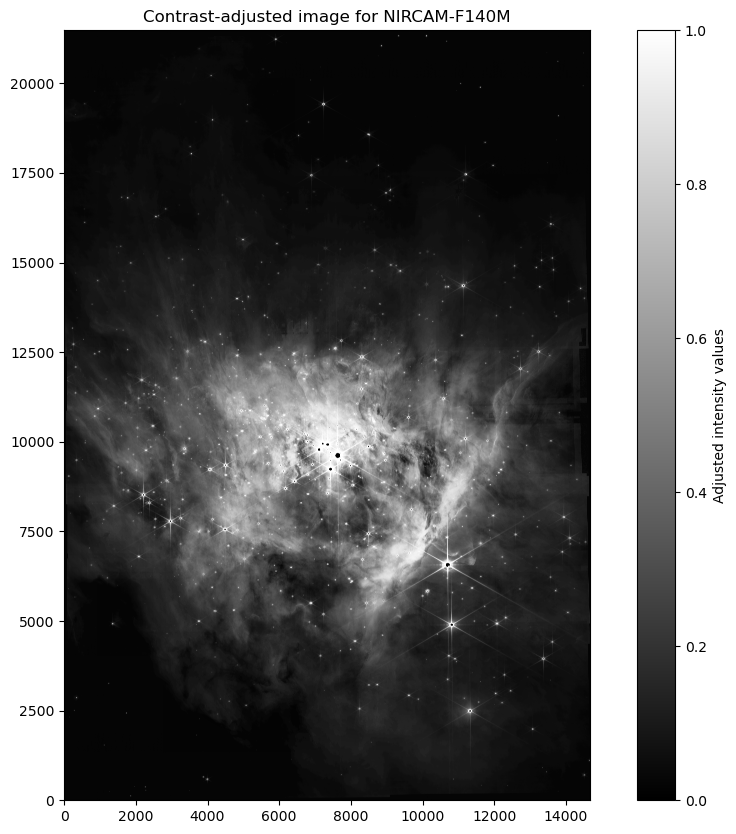

Reprojecting NIRCAM-F140M to match NIRCAM-F187N...
This may take a while for large images...
Processing rows 0 to 3405...
Processing rows 3405 to 6810...
Processing rows 6810 to 10215...
Processing rows 10215 to 13620...
Processing rows 13620 to 17025...
Processing rows 17025 to 20430...
Processing rows 20430 to 21477...
Reprojection of NIRCAM-F140M complete!


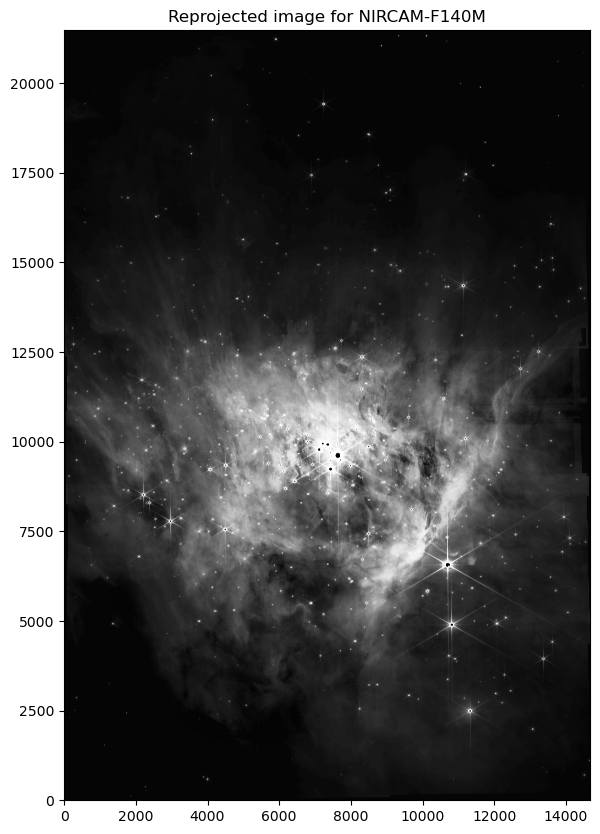

Saving layer image to layers/JW01256_NIRCAM-F140M.png

Processing NIRCAM-F187N...


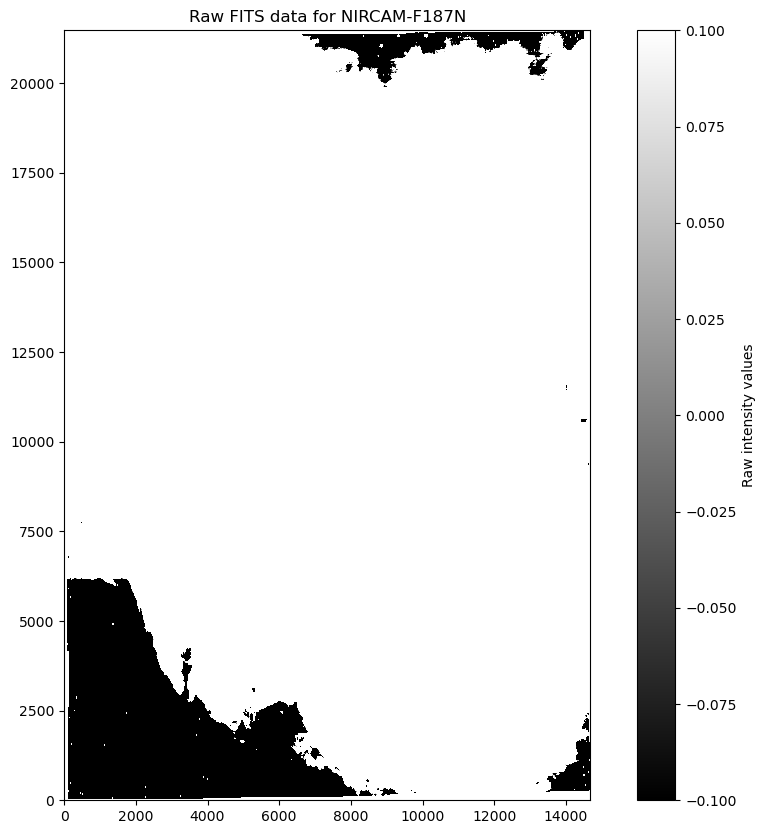

Stretching contrast: clipping values below 4.361379 and above 3776.214506
Applying adaptive histogram equalization...


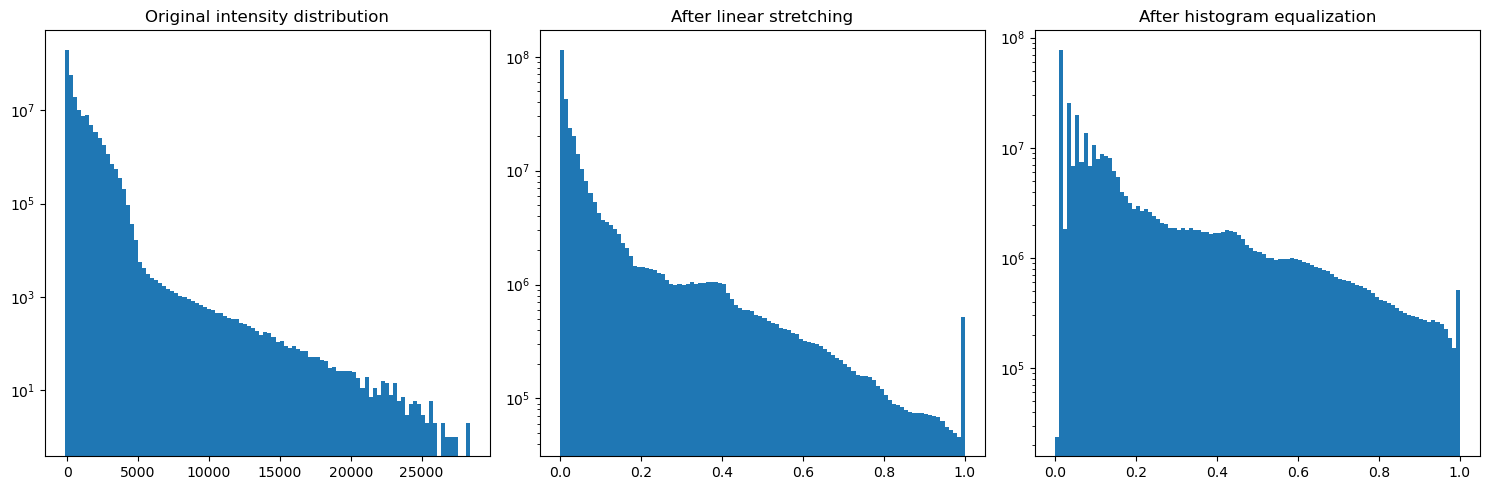

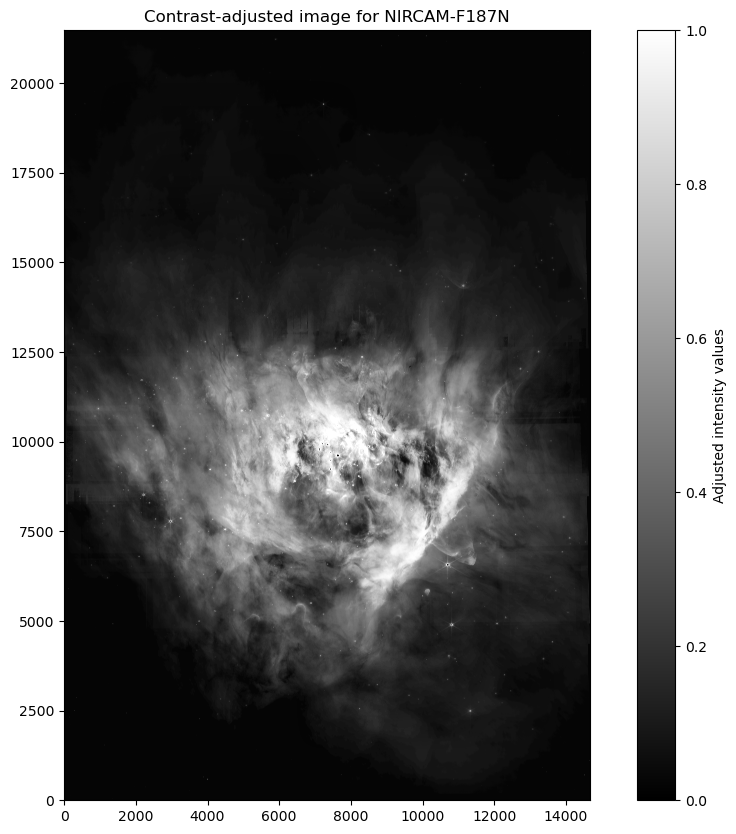

Saving layer image to layers/JW01256_NIRCAM-F187N.png

Processing NIRCAM-F212N...


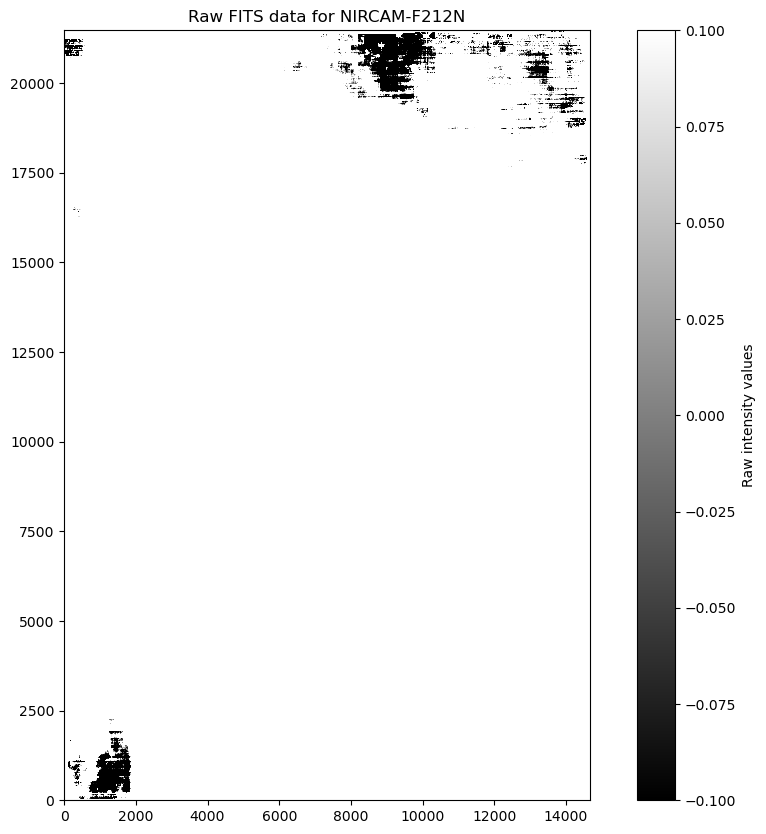

Stretching contrast: clipping values below 1.751337 and above 665.221375
Applying adaptive histogram equalization...


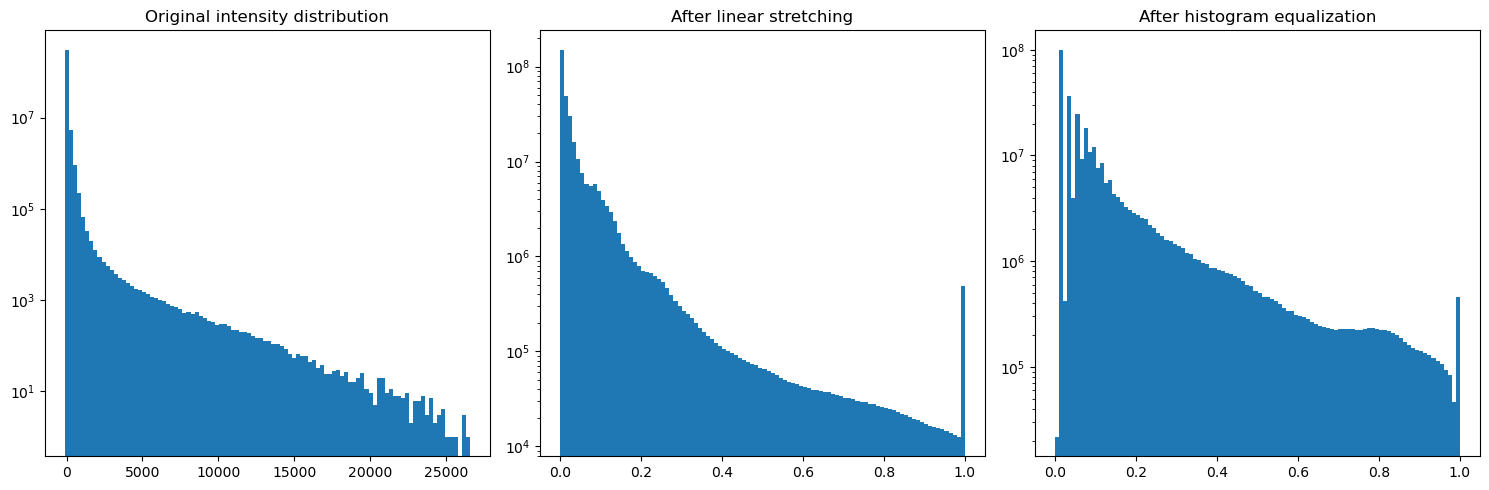

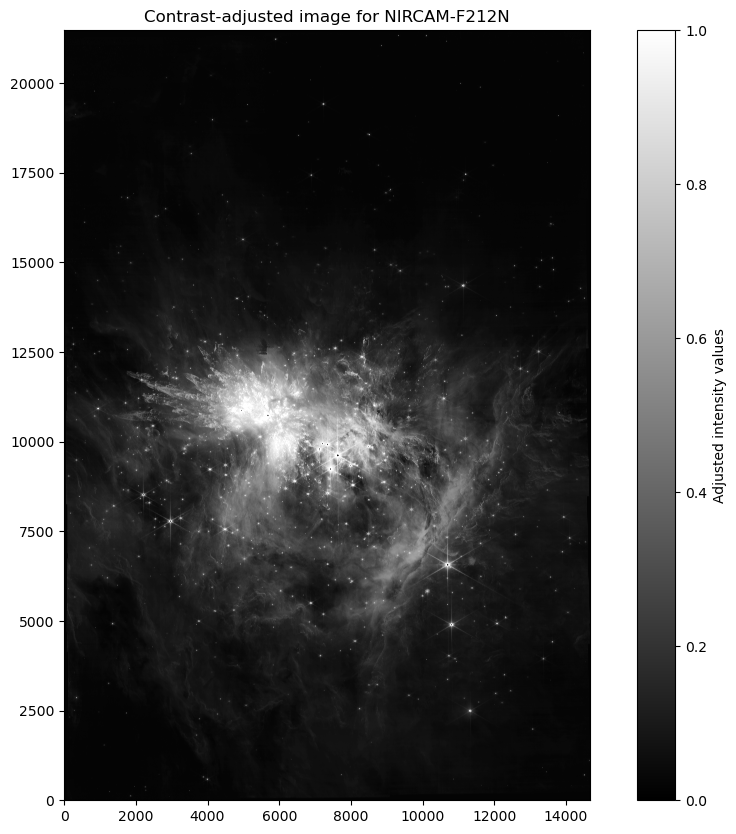

Reprojecting NIRCAM-F212N to match NIRCAM-F187N...
This may take a while for large images...
Processing rows 0 to 3405...
Processing rows 3405 to 6810...
Processing rows 6810 to 10215...
Processing rows 10215 to 13620...
Processing rows 13620 to 17025...
Processing rows 17025 to 20430...
Processing rows 20430 to 21477...
Reprojection of NIRCAM-F212N complete!


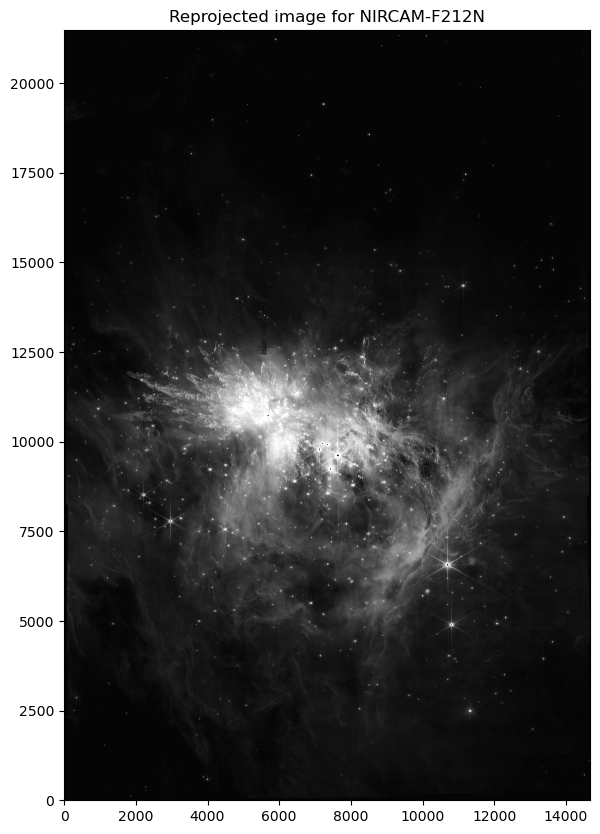

Saving layer image to layers/JW01256_NIRCAM-F212N.png

Creating colorized layer for NIRCAM-F277W...
Created layer: NIRCAM-F277W
HSV values: H=118.0°, S=50.6%, V=100.0%


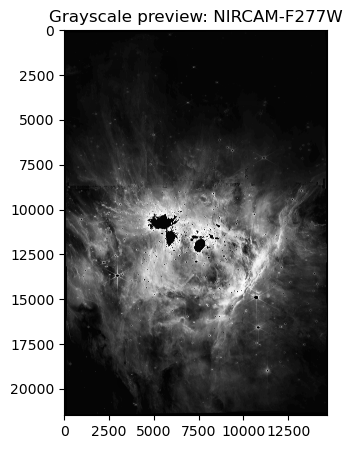

Colorizing NIRCAM-F277W with HSV: (118.0°, 50.6%, 100.0%)


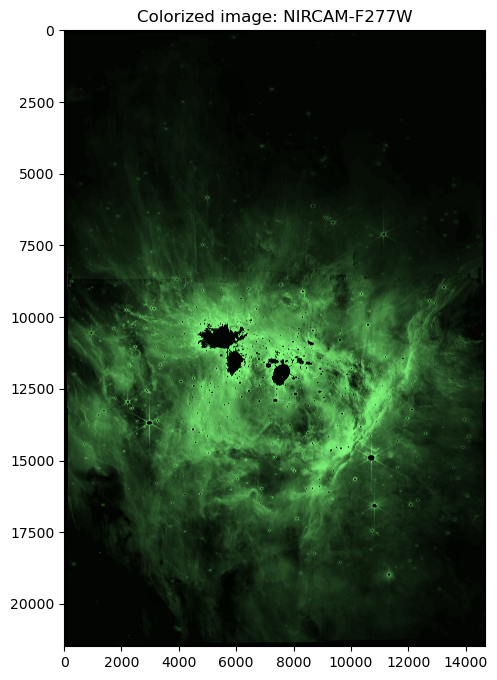


Creating colorized layer for NIRCAM-F182M...
Created layer: NIRCAM-F182M
HSV values: H=209.5°, S=83.5%, V=100.0%


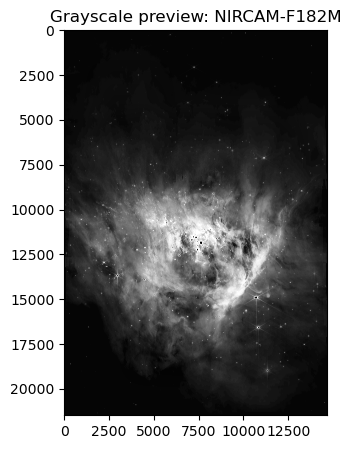

Colorizing NIRCAM-F182M with HSV: (209.5°, 83.5%, 100.0%)


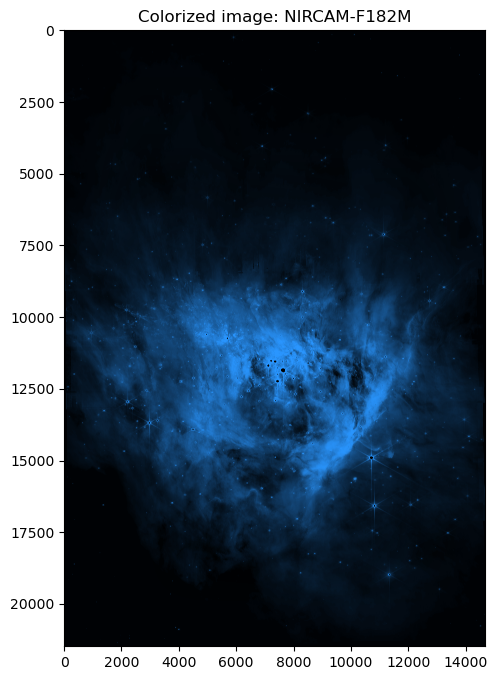


Creating colorized layer for NIRCAM-F300M...
Created layer: NIRCAM-F300M
HSV values: H=93.9°, S=77.4%, V=100.0%


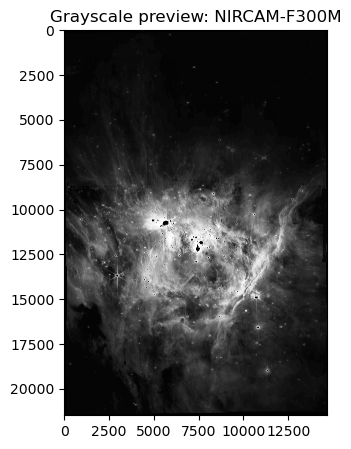

Colorizing NIRCAM-F300M with HSV: (93.9°, 77.4%, 100.0%)


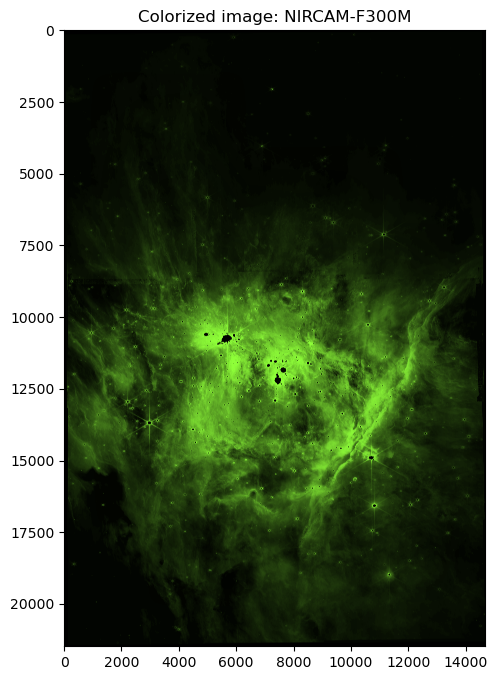


Creating colorized layer for NIRCAM-F140M...
Created layer: NIRCAM-F140M
HSV values: H=230.4°, S=90.8%, V=100.0%


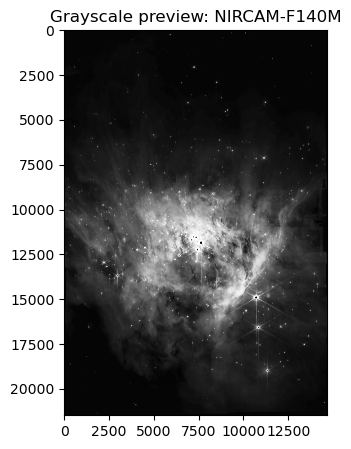

Colorizing NIRCAM-F140M with HSV: (230.4°, 90.8%, 100.0%)


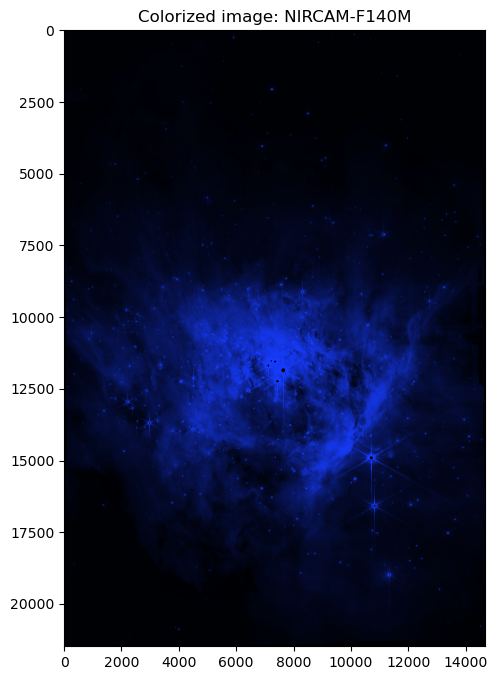


Creating colorized layer for NIRCAM-F187N...
Created layer: NIRCAM-F187N
HSV values: H=207.6°, S=99.7%, V=100.0%


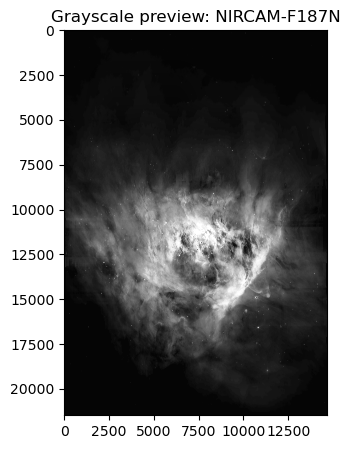

Colorizing NIRCAM-F187N with HSV: (207.6°, 99.7%, 100.0%)


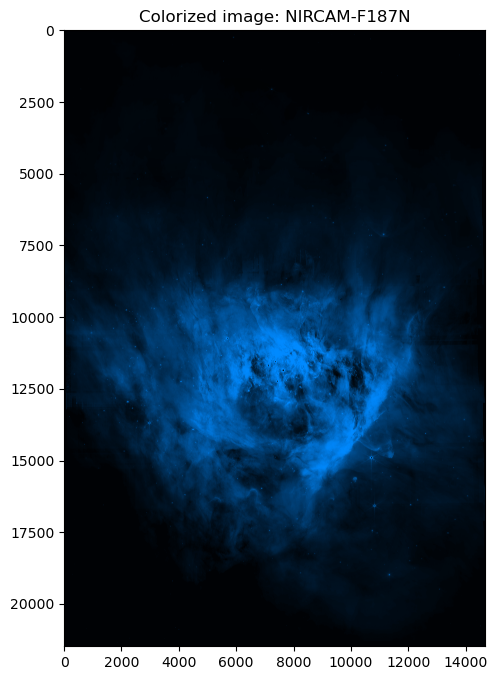


Creating colorized layer for NIRCAM-F212N...
Created layer: NIRCAM-F212N
HSV values: H=188.6°, S=99.5%, V=100.0%


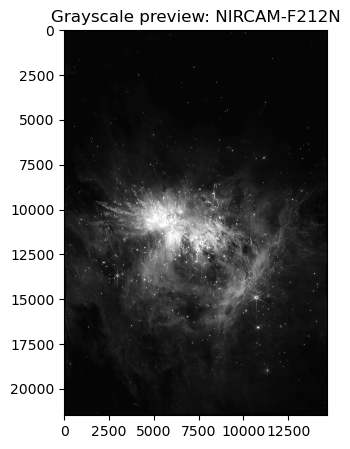

Colorizing NIRCAM-F212N with HSV: (188.6°, 99.5%, 100.0%)


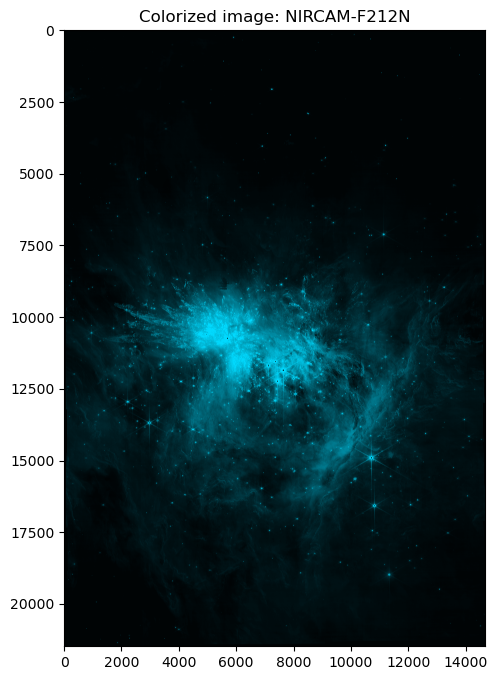


Blending all layers together...
Blending 6 images with brightness factor of 0.70


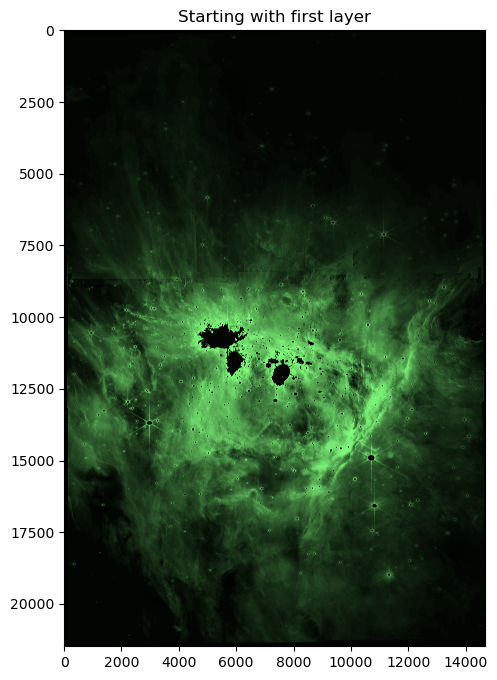

In [ ]:
#Cell 7: Usage Example - Process FITS files
#========================================

# Usage Example - Process FITS files

# Modify the paths below to process your FITS files
fits_folder = "fits"  # Folder containing your FITS files
output_image = "output/my_jwst_image.jpg"  # Where to save the final image
layers_folder = "layers"  # Where to save individual layer images

# Process the FITS files
process_fits_folder(fits_folder, output_image, layers_folder)

print("Imagen creada con exito!, revise la carpeta output/")

**Nota (celda 8) — Código auxiliar de soporte para el flujo del tutorial.**



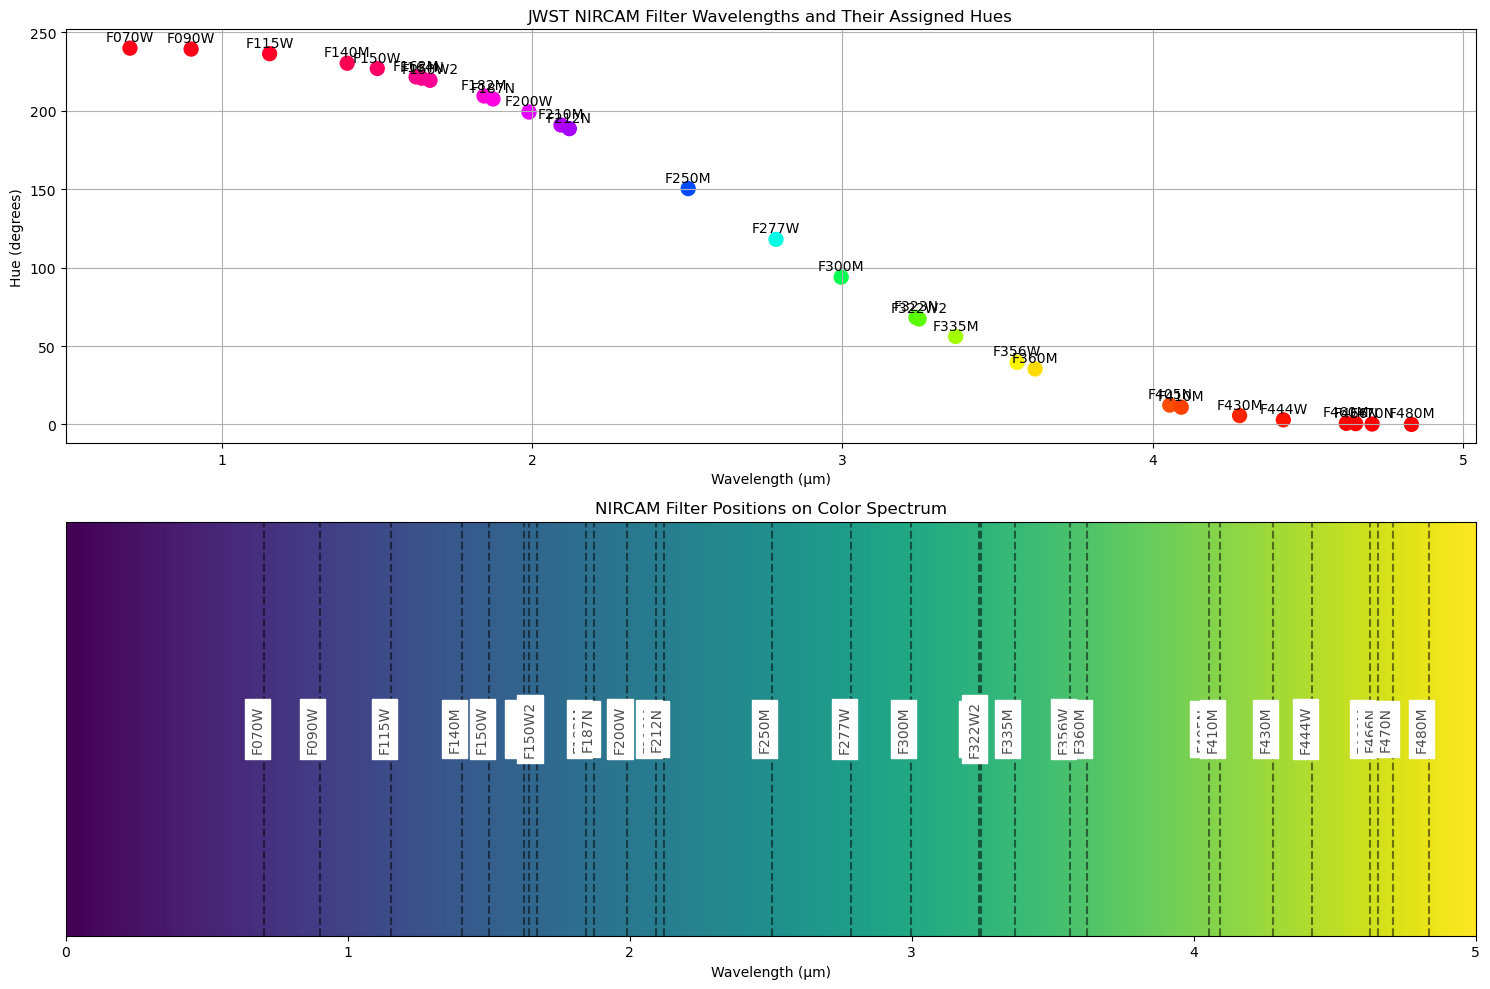

JWST Color Assignment Explanation:
----------------------------------
1. JWST captures images in infrared light, which is invisible to human eyes.
2. To create visible images, we assign colors to different wavelengths.
3. Generally, shorter wavelengths are assigned bluer colors (higher hue values).
4. Longer wavelengths are assigned redder colors (lower hue values).
5. An S-curve adjustment is applied to the mapping to avoid too much green.
6. Filter bandwidth affects saturation - narrower filters get higher saturation.

The plot shows how each NIRCAM filter's wavelength maps to a hue value.


In [8]:
# Cell 8: Understanding the JWST Color Assignment
# =============================================

def visualize_filter_wavelengths():
    """
    Visualize how filter wavelengths correspond to the HSV color space.
    """
    # Collect NIRCAM filter data
    nircam_filters = WebbFilters.FILTERS["NIRCAM"].list
    
    # Sort by wavelength
    nircam_filters.sort(key=lambda x: x.wavelength)
    
    # Calculate HSV values for each filter
    filter_data = []
    for filter in nircam_filters:
        hue, saturation = WebbsterLayer.get_filter_hue_saturation(filter)
        hue_degrees = hue * 360
        filter_data.append({
            'name': filter.name,
            'wavelength': filter.wavelength,
            'bandwidth': filter.bandwidth,
            'hue': hue_degrees,
            'saturation': saturation * 100
        })
    
    # Create a visualization
    plt.figure(figsize=(15, 10))
    
    # Plot wavelength vs hue
    plt.subplot(2, 1, 1)
    wavelengths = [f['wavelength'] for f in filter_data]
    hues = [f['hue'] for f in filter_data]
    names = [f['name'] for f in filter_data]
    
    plt.scatter(wavelengths, hues, c=hues, cmap='hsv', s=100)
    
    # Add filter names as labels
    for i, name in enumerate(names):
        plt.annotate(name, (wavelengths[i], hues[i]), 
                     textcoords="offset points", 
                     xytext=(0, 5), 
                     ha='center')
    
    plt.xlabel('Wavelength (μm)')
    plt.ylabel('Hue (degrees)')
    plt.title('JWST NIRCAM Filter Wavelengths and Their Assigned Hues')
    plt.grid(True)
    
    # Plot the color spectrum with filter positions
    plt.subplot(2, 1, 2)
    
    # Create a horizontal color spectrum
    gradient = np.linspace(0, 1, 1000)
    gradient = np.vstack((gradient, gradient))
    
    # Create colors for each point
    colors = []
    for i in range(len(gradient[0])):
        # Map position to hue (reversed to match the mapping we use)
        hue = 240 * (1 - i/len(gradient[0]))
        colors.append([hue/360, 1, 1])
    
    # Convert HSV to RGB
    colors = color.hsv2rgb(colors)
    
    # Plot the color spectrum
    plt.imshow(gradient, aspect='auto', extent=[0, 5.0, 0, 1], origin='lower')
    
    # Mark filter positions
    for f in filter_data:
        plt.axvline(x=f['wavelength'], color='black', linestyle='--', alpha=0.5)
        plt.text(f['wavelength'], 0.5, f['name'], 
                 rotation=90, va='center', ha='right',
                 backgroundcolor='white', alpha=0.7)
    
    plt.xlabel('Wavelength (μm)')
    plt.title('NIRCAM Filter Positions on Color Spectrum')
    plt.yticks([])
    
    plt.tight_layout()
    plt.show()
    
    # Print explanation
    print("JWST Color Assignment Explanation:")
    print("----------------------------------")
    print("1. JWST captures images in infrared light, which is invisible to human eyes.")
    print("2. To create visible images, we assign colors to different wavelengths.")
    print("3. Generally, shorter wavelengths are assigned bluer colors (higher hue values).")
    print("4. Longer wavelengths are assigned redder colors (lower hue values).")
    print("5. An S-curve adjustment is applied to the mapping to avoid too much green.")
    print("6. Filter bandwidth affects saturation - narrower filters get higher saturation.")
    print("\nThe plot shows how each NIRCAM filter's wavelength maps to a hue value.")

visualize_filter_wavelengths()

# Exercises #

# Find the FITS files and make the images for: #

use the MAST repository: https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html


## Nebulosas

(1) NGC 3372 – Nebulosa de Carina

(2) NGC 1952 (M1) – Nebulosa del Cangrejo

(3) NGC 6611 (M16) – Pillars of Creation

(4) Tarantula Nebula – 30 Doradus 

(5) NGC 3132 – Southern Ring Nebula (planetaria): caparazón con polvo y gas

(6) Horsehead Nebula (Barnard 33)

(7) M57 – Ring Nebula

(8) Orion Bar (M42)

(9) NGC 346 – cúmulo estelar joven en la Pequeña Nube de Magallanes

(10) HCG 92  –  Stephan’s Quintet
